### Import all the relevant libraries

In [146]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sobol_seq

In [147]:
pd.set_option('display.max_columns', None)

### Define a few functions to be used in the computation

In [148]:
def Y(Alpha,Beta,r,N0,Gamma,Year0):
    return Alpha*(N0**(1-Gamma)+r*(2050-Year0)*(1-Gamma))**(Beta/(1-Gamma))

def create_dict(key, values):
    return dict(zip(key, values))

def trigger_index(t):
    return np.sum(t*[len(lu_pop)/len(Areas2),len(lu_pop)/(len(Areas2)*len(dataSets)),len(lu_pop)/(len(Areas2)*len(dataSets)*
len(Regression_Method)),len(lu_pop)/(len(Areas2)*len(dataSets)*len(Regression_Method)*len(Robustness)),1],axis=1).astype(int)

def trigger_index_water(t):
    return np.sum(t*[len(lu_water)/len(Areas2),len(lu_water)/(len(Areas2)*len(dataSets)),
                len(lu_water)/(len(Areas2)*len(dataSets)*len(Robustness)),1],axis=1).astype(int)

### Read the input parameters

### irrArea = pd.read_excel('draft_1/full.dataset2.xlsx',sheet_name='meier')

Areas2 = ['Africa','Americas','Asia','Europe']
dataSets = ['Aquastat','FAOSTAT','Meier.et.al.2018','Salmon.et.al.2015','Siebert.et.al.2013','Thenkabail.et.al.2009']
Regression_Method = ['OLS','SMA']
Robustness = ['YES','NO']
sl = [['OLS','NO'],['OLS','YES'],['SMA','NO'],['SMA','YES']]
Y0 = pd.DataFrame([irrArea[irrArea['Continent']==ar2].sum() for ar2 in Areas2], index=[ar2 for ar2 in Areas2])
Y0=Y0.iloc[:,3:]/1e6
Y0=Y0.reindex(sorted(Y0.columns), axis=1)

In [150]:
p3 = pd.read_csv('A.matrix.csv')

In [151]:
p3 = p3.rename(index=str, columns={"X1":"Dataset","X2":"Regression","X3":"Robust"})

### Prepare the dataset

In [152]:
lu_pop = pd.read_csv('lookup.pop.csv',header=0)
lu_pop = lu_pop.sort_values(by=['Continent','Dataset','Regression','Robust','Beta']).reset_index(drop=True)
lu_water = pd.read_csv('lookup.water.csv',header=0)
lu_water = lu_water.sort_values(by=['Continent','Dataset','Robust','Delta']).reset_index(drop=True)

### Set the lookup table

In [153]:
lu_water = lu_water.rename(columns={'Continent':'Continent_w','Dataset':'Dataset_w','Regression':'Regression_w',
                                   'Robust':'Robust_w'})

### K setting the carrying capacity factor (cropland available)

In [154]:
K = pd.DataFrame([[7.14e8,8.85e8,6.68e8,4.78e8],[1.205e9,1.481e9,8.89e8,7.05e8]],columns=[ar2 for ar2 in Areas2],index=\
                    ['Net','Gross']).T
K = K/1.e6

### $W_a$ setting the water carrying capacity factor (water available)

In [155]:
Wa = pd.DataFrame([[3142,15629,8851,5261],[4714,23553,13277,7891]],columns=[ar2 for ar2 in Areas2],index=\
                    ['Lower','Upper']).T

### $\eta$ water available share for irrigation

In [156]:
eta = pd.Series([0.2,0.5],index=['Lower','Upper'])

### Quasi-random matrix for the Monte Carlo simulations

In [157]:
qM =sobol_seq.i4_sobol_generate(28,2**15)

### Building the triggers for the lookup table

In [158]:
continent_v = np.array(list(itertools.chain.from_iterable(itertools.repeat(x, 2**15) 
for x in range(len(Areas2)))))

triggers = np.vstack((continent_v,np.tile((qM[:,0:4]*[6,2,2,10_000]).T,4))).astype(int)

triggers_w = np.vstack((continent_v,np.tile((qM[:,4:7]*[6,2,10_000]).T,4))).astype(int)

triggersB = np.vstack((continent_v,np.tile((qM[:,14:18]*[6,2,2,10_000]).T,4))).astype(int)

triggers_wB = np.vstack((continent_v,np.tile((qM[:,18:21]*[6,2,10_000]).T,4))).astype(int)

### Adjust the database to $2^{15}$ values

In [159]:
p4 = p3.r
p4B = pd.read_csv('B.matrix.csv')['r']

### Define the coefficients for the alpha regression in terms of Beta

In [160]:
a =  -0.4897174
b = -1.245234
epsilon = 0.1579309

### Population initial figures

In [161]:
PPop = pd.read_csv('draft_1/UN_PP1999-2012.csv')
del PPop['Variant']
PPop = PPop.rename(columns={'Country or Area':'Continent','Year(s)':'Year'})
PPop=PPop.pivot(index='Continent',columns='Year',values='Value')
PPop.loc['Americas']=PPop.loc['Latin America and the Caribbean']+PPop.loc['Northern America']
PPop = PPop.drop(['Latin America and the Caribbean','Northern America'])
PPop = PPop.sort_index()

In [162]:
tr_As = [triggers] 
for tr in range(1,len(triggers)):
    tr_As.append(triggers.copy())
    tr_As[tr][tr]=triggersB[tr]

tr_As_w = [triggers_w] 
for tr in range(1,len(triggers_w)):
    tr_As_w.append(triggers_w.copy())
    tr_As_w[tr][tr]=triggers_wB[tr]
    
tr_Bs = [triggersB] 

tr_Bs_w = [triggers_wB] 
    
tIndexA = [trigger_index(tri.T) for tri in tr_As]
tIndexB = [trigger_index(triB.T) for triB in tr_Bs]

tIndexA_w = [trigger_index_water(tri.T) for tri in tr_As_w]
tIndexB_w = [trigger_index_water(triB.T) for triB in tr_Bs_w]

In [163]:
sM_As = []
for itI,tI in enumerate(tIndexA):
    sM_As.append(lu_pop.copy())
    sM_As[itI]=sM_As[itI].reindex(tI)
    sM_As[itI]=sM_As[itI].reset_index(drop=True)
    
sM_Bs = []
for itIB,tIB in enumerate(tIndexB):
    sM_Bs.append(lu_pop.copy())
    sM_Bs[itIB]=sM_Bs[itIB].reindex(tIB)
    sM_Bs[itIB]=sM_Bs[itIB].reset_index(drop=True)
    
sM_As_w = []
for itI,tI in enumerate(tIndexA_w):
    sM_As_w.append(lu_water.copy())
    sM_As_w[itI]=sM_As_w[itI].reindex(tI)
    sM_As_w[itI]=sM_As_w[itI].reset_index(drop=True)
    sM_As_w[itI]=pd.concat([sM_As[0],sM_As_w[itI]],axis=1)
    
sM_Bs_w = []
for itIB,tIB in enumerate(tIndexB_w):
    sM_Bs_w.append(lu_water.copy())
    sM_Bs_w[itIB]=sM_Bs_w[itIB].reindex(tIB)
    sM_Bs_w[itIB]=sM_Bs_w[itIB].reset_index(drop=True)
    sM_Bs_w[itIB]=pd.concat([sM_Bs[0],sM_Bs_w[itIB]],axis=1)

sM_A = []    
for sma in sM_As:
    sM_A.append(pd.concat([sma,sM_As_w[0].iloc[:,6:]],axis=1))

sM_B = []    
for smb in sM_Bs:
    sM_B.append(pd.concat([smb,sM_Bs_w[0].iloc[:,6:]],axis=1))

sM_A.extend(sM_As_w[1:])
sM_B.extend(sM_Bs_w[1:])

### Fix all the parameters

In [164]:
for sm in sM_A:
    sm['r']=p4.values
    sm['Year0'] = np.tile((PPop.columns.min()+(PPop.columns.max()-PPop.columns.min()+1)*qM[:,10]).astype(int),4)
    sm['Gamma']= np.tile(0.02*2**0.5*sp.special.erfinv(2*qM[:,8]-1)+1,4)
    sm['Y0']=0
    sm['K']=0
    sm['Wa']=0
    sm['eta']=np.tile(eta['Lower']+qM[:,13]*(eta['Upper']-eta['Lower']),4)
    for ar2 in Areas2:
        sm.loc[sm['Continent']==ar2,'Y0']=Y0.loc[ar2].min()+qM[:,9]*(Y0.loc[ar2].max()-Y0.loc[ar2].min())
        sm.loc[sm['Continent']==ar2,'K']=K['Net'].loc[ar2]+qM[:,11]*(K['Gross'].loc[ar2]-K['Net'].loc[ar2])
        sm.loc[sm['Continent']==ar2,'Wa']=Wa['Lower'].loc[ar2]+qM[:,12]*(Wa['Upper'].loc[ar2]-Wa['Lower'].loc[ar2])
    sm['N0']=[PPop[smy][ar2]/1.e3 for ar2 in Areas2 for smy in sm['Year0'][:int(len(sm)/4)]]
    sm['Alpha']=sm.Y0/(sm.N0)**sm.Beta
        
for smB in sM_B:
    smB['r']=p4B.values
    smB['Year0'] = np.tile((PPop.columns.min()+(PPop.columns.max()-PPop.columns.min()+1)*qM[:,24]).astype(int),4)
    smB['Gamma']= np.tile(0.02*2**0.5*sp.special.erfinv(2*qM[:,22]-1)+1,4)
    smB['Y0']=0
    smB['K']=0
    smB['Wa']=0
    smB['eta']=np.tile(eta['Lower']+qM[:,27]*(eta['Upper']-eta['Lower']),4)
    for ar2 in Areas2:
        smB.loc[smB['Continent']==ar2,'Y0']=Y0.loc[ar2].min()+qM[:,23]*(Y0.loc[ar2].max()-Y0.loc[ar2].min())
        smB.loc[smB['Continent']==ar2,'K']=K['Net'].loc[ar2]+qM[:,25]*(K['Gross'].loc[ar2]-K['Net'].loc[ar2])
        smB.loc[smB['Continent']==ar2,'Wa']=Wa['Lower'].loc[ar2]+qM[:,26]*(Wa['Upper'].loc[ar2]-Wa['Lower'].loc[ar2])
    smB['N0']=[PPop[smy][ar2]/1.e3 for ar2 in Areas2 for smy in smB['Year0'][:int(len(smB)/4)]]
    smB['Alpha']=smB.Y0/(smB.N0)**smB.Beta

### Define the variables list for the scrambled matrices

In [166]:
variables2 = [['r'],['Y0','Alpha'],['Year0','N0'],['Gamma'],['K'],['Wa'],['eta']]

In [167]:
variables = [['Dataset'],['Regression'],['Robust'],['X4'],['Dataset_w'],['Robust_w'],['w4'],['r'],['Y0','Alpha'],['Year0','N0'],
             ['Gamma'],['K'],['Wa'],['eta']]

In [168]:
for iv,v in enumerate(variables2):
    sM_A.append(sM_A[0].copy())
    sM_A[-1][v]=sM_B[0][v]
    sM_A[-1]['Alpha']=sM_A[-1].Y0/(sM_A[-1].N0)**sM_A[-1].Beta

In [169]:
for sm in sM_A:
    sm['Y']=Y(sm.Alpha,sm.Beta,sm.r,sm.N0,sm.Gamma,sm.Year0)
    sm.loc[sm['Y']>sm.K,'Y'] = sm.K
    sm.loc[(sm.Wa*sm.eta<sm.Y**sm.Delta*10**sm.Phi)&((sm.Wa*sm.eta/10**sm.Phi)**(1/sm.Delta) > sm.Y0),'Y'] = \
    (sm.Wa*sm.eta/10**sm.Phi)**(1/sm.Delta)
    sm.loc[(sm.Wa*sm.eta<sm.Y**sm.Delta*10**sm.Phi)&((sm.Wa*sm.eta/10**sm.Phi)**(1/sm.Delta) < sm.Y0),'Y'] = \
    sm.Y0
    sm.loc[sm['Y']<0,'Y'] = sm.Y0
    
        
for smB in sM_B:
    smB['Y']=Y(smB.Alpha,smB.Beta,smB.r,smB.N0,smB.Gamma,smB.Year0)
    smB.loc[smB['Y']>smB.K,'Y'] = smB.K
    smB.loc[(smB.Wa*smB.eta<smB.Y**smB.Delta*10**smB.Phi)&((smB.Wa*smB.eta/10**smB.Phi)**(1/smB.Delta) 
            > smB.Y0),'Y'] = (smB.Wa*smB.eta/10**smB.Phi)**(1/smB.Delta)
    smB.loc[(smB.Wa*smB.eta<smB.Y**smB.Delta*10**smB.Phi)&((smB.Wa*smB.eta/10**smB.Phi)**(1/smB.Delta)
            < smB.Y0),'Y'] = smB.Y0
    smB.loc[smB['Y']<0,'Y'] = sm.Y0

### Append the B matrix for the Sobol-indices computation

In [170]:
sM_S = sM_A.copy()
sM_S.append(sM_B[0])

### Narrow down the indices in order to get rid of potential 'orphan' (uncoupled) rows across the matrices

In [171]:
inr = sM_S[0].index.intersection(sM_S[1].index).intersection(sM_S[2].index).intersection(sM_S[3].index).\
intersection(sM_S[4].index).intersection(sM_S[5].index).intersection(sM_S[6].index).intersection(sM_S[7].index).\
intersection(sM_S[8].index).intersection(sM_S[9].index).intersection(sM_S[10].index).intersection(sM_S[11].index).\
intersection(sM_S[12].index).intersection(sM_S[13].index).intersection(sM_S[14].index).intersection(sM_S[15].index)

sM_S = [sms.merge(pd.DataFrame(index=inr), left_index=True, right_index=True, how='right').reset_index(drop=True) for sms in sM_S]

### Assess the Global Irrigated Area in 2050

In [172]:
worldIrrigatedArea = pd.concat([sM_A[0].Y[ia*int(len(sM_A[0].Y)/len(Areas2)):(ia+1)*int(len(sM_A[0].Y)/len(Areas2))].reset_index(drop=True) 
                                for ia in range(len(Areas2))],axis=1,ignore_index=True).sum(axis=1)

### Bootstrap sensitivity indices

In [173]:
c_r = []
T_r = []
Sa_r = []
for re in range(1_000):    
    seed = sM_S[0].sample(frac=1,replace=True).sort_index().index
    sM_BS = [smS.reindex(seed) for smS in sM_S]

    V = []
    Sa_V = []
    T_V = []
    
    for imb,mb in enumerate(sM_BS[1:-1]):
        Geo = []
        Sa_G = []
        T_G = []
        for ar2 in Areas2:
            Var = np.var(np.concatenate((sM_BS[-1]['Y'][sM_BS[-1]['Continent']==ar2].values,
                             sM_BS[0]['Y'][sM_BS[0]['Continent']==ar2].values),axis=None),ddof=0)
            Sa_G.append(np.mean((mb['Y'][mb['Continent']==ar2].values-sM_BS[0]['Y'][sM_BS[0]['Continent']==ar2].values)*\
                         sM_BS[-1]['Y'][sM_BS[-1]['Continent']==ar2].values)/Var)
            T_G.append(0.5*(np.mean((mb['Y'][mb['Continent']==ar2].values-sM_BS[0]['Y'][sM_BS[0]['Continent']==ar2].values)**2))/\
                       Var)
            Geo.append(ar2)
        Sa_G_dic = create_dict(Geo,Sa_G)
        T_G_dic = create_dict(Geo,T_G)
        V.append(variables[imb][0])
        Sa_V.append(Sa_G_dic)
        T_V.append(T_G_dic)
    Sa_V_dic = create_dict(V,Sa_V)
    T_V_dic = create_dict(V,T_V)
    
    c_r.append(re)
    Sa_r.append(Sa_V_dic)
    T_r.append(T_V_dic)
Sa_r_dic = create_dict(c_r,Sa_r)
T_r_dic = create_dict(c_r,T_r)
Sa_of_df = {Sa_k: pd.DataFrame(Sa_v) for Sa_k,Sa_v in Sa_r_dic.items()}
T_of_df = {T_k: pd.DataFrame(T_v) for T_k,T_v in T_r_dic.items()}
T_df = pd.concat(T_of_df, axis=0)
Sa_df = pd.concat(Sa_of_df, axis=0)

### Irrigated Land Area Distribution plots

In [174]:
co = ['b','r','g','k','c','m']
plt.style.use('ggplot')
for ar2 in Areas2:
    ax = sns.distplot(sM_A[0].Y[sM_A[0].Continent==ar2], bins=30, kde=False, axlabel='Irrigated Area 2050 (ha)_'+str(ar2))
    ax.set_xscale('log')
    ax.set_ylabel('Count')
    for ds in K:
        plt.axvline(x=K[ds][ar2],label=str(ds)+' Cropland in 2050')
    plt.legend()
    plt.xlim(1,1.e3)
    plt.show()

### Distribution plots World Area

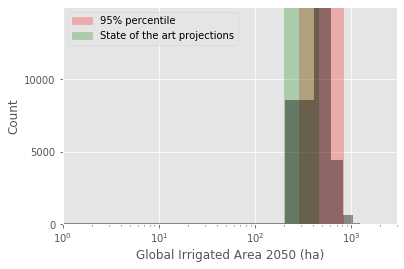

In [176]:
plt.style.use('ggplot')
ax = sns.distplot(worldIrrigatedArea, bins=10, kde=False, color='k',axlabel='Global Irrigated Area 2050 (ha)')
ax.set_xscale('log')
ax.set_ylabel('Count')
plt.fill_between((worldIrrigatedArea.quantile(.025),worldIrrigatedArea.quantile(.975)),(15000,15000),color='r',alpha=0.25,
                label='95% percentile')
plt.fill_between((2.e2,4.5e2),(15000,15000),color='g',alpha=0.25,label='State of the art projections')
plt.yticks(np.arange(0, 1.5e4, step=5e3))
plt.ylim(0,1.5e4)
plt.xlim(1,3.e3)
plt.legend()
plt.show()

### Scatter Plots

In [178]:
co = ['Dataset','Regression','Robust','r','Y0','Year0','Gamma','K']
for ar2 in Areas2:
    for col in co:
        plt.figure(figsize=(20,10))
        plt.scatter(sM_A[0][col][sM_A[0].Continent==ar2],sM_A[0]['Y'][sM_A[0].Continent==ar2],s=1,label=str(ar2)+'_'+str(col))
        plt.yscale('log')
        plt.ylim(1.,2.e3)
        plt.legend()
        plt.show()

### Sensitivity-indices boxplots

In [179]:
for ar2 in Areas2:
    fig, ax = plt.subplots(figsize=(20,10))
    for iv,v in enumerate(variables):
        T_df.loc[pd.IndexSlice[:, ar2],:].plot(kind='box',ax=ax,label='T', color='b',patch_artist=True)
        Sa_df.loc[pd.IndexSlice[:, ar2],:].plot(kind='box',ax=ax,label='S',positions=[iv+0.5 for iv in range(len(variables))],
                                              color='r',patch_artist=True)
    m_patch = mpatches.Patch(color='b'
                             , label='T')
    c_patch = mpatches.Patch(color='r', label='S')
    plt.legend(handles=[m_patch,c_patch])
    plt.xticks([iv+0.75 for iv in range(len(variables))])
    plt.xlim(0,15.5)
    plt.title(ar2)
    plt.show()